# Implement on Kaggle

In [2]:
!conda install -y gdown

Retrieving notices: ...working... done
^C

CondaError: KeyboardInterrupt



# Upload data from Gdrive

In [2]:
import gdown 
url = 'https://drive.google.com/uc?id=1qpERnSnAs6RiFmWSzAEgagw4grq1I-b8' 
output = 'trainig_set_no_outliers.npz'
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1qpERnSnAs6RiFmWSzAEgagw4grq1I-b8
From (redirected): https://drive.google.com/uc?id=1qpERnSnAs6RiFmWSzAEgagw4grq1I-b8&confirm=t&uuid=990301a2-4803-4f11-a91d-e1f37a64563d
To: /kaggle/working/trainig_set_no_outliers.npz
100%|██████████| 330M/330M [00:02<00:00, 114MB/s]  


'trainig_set_no_outliers.npz'

In [3]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import keras_cv

from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow.random import gamma as tf_random_gamma
import keras 

In [ ]:
def plot_individual_and_combined_augmentations(augmentation_layers, image):
    """
    Applies each augmentation layer independently to the image and displays each result.
    Also displays the result of applying all augmentations sequentially at the end.
    
    Parameters:
    - augmentation_layers: tf.keras.Sequential - a sequential model containing augmentation layers.
    - image: numpy array - the source image in [0, 1] range to augment and display.
    """
    # Ensure image is in 4D shape: (1, height, width, channels) for batch processing
    img_array = tf.expand_dims(image, axis=0)
    
    # Convert image from [0, 1] to [0, 255] for display purposes
    img_display = (image * 255).astype("uint8")
    
    plt.figure(figsize=(15, 8))
    plt.subplot(3, 4, 1)
    plt.imshow(img_display)
    plt.title("Original Image")
    plt.axis("off")
    
    # Loop through each augmentation layer for individual application
    for i, layer in enumerate(augmentation_layers.layers):
        # Apply the individual layer to the image
        augmented_img = layer(img_array, training=True)  # Training=True to apply augmentation
        
        # Convert augmented image from [0, 1] to [0, 255] for display
        augmented_img_display = tf.squeeze(augmented_img).numpy() * 255
        augmented_img_display = augmented_img_display.astype("uint8")
        
        # Get the layer name and parameters
        layer_name = layer.__class__.__name__
        layer_params = layer.get_config()  # Dictionary of parameters
        params_text = ", ".join(f"{k}={v}" for k, v in layer_params.items() if k != 'name')
        
        # Plot the augmented image
        plt.subplot(3, 4, i + 2)
        plt.imshow(augmented_img_display)
        plt.title(f"{layer_name}")
        plt.axis("off")
    
    # Apply all augmentations sequentially on the original image (remove batch dimension here)
    combined_augmented_img = augmentation_layers(tf.squeeze(img_array), training=True)
    
    # Convert combined augmented image from [0, 1] to [0, 255] for display
    combined_augmented_img_display = combined_augmented_img.numpy() * 255
    combined_augmented_img_display = combined_augmented_img_display.astype("uint8")
    
    # Plot the image with all augmentations applied
    plt.subplot(3, 4, len(augmentation_layers.layers) + 2)
    plt.imshow(combined_augmented_img_display)
    plt.title("All Augmentations Applied")
    plt.axis("off")
    
    plt.suptitle("Original, Individual Augmentations, and Combined Augmentation")
    plt.tight_layout()
    plt.show()


# [MixUp augmentation](https://keras.io/examples/vision/mixup/)

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf_random_gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf_random_gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(ds_one, ds_two, alpha=0.2):
    """
    apply MixUp augmentation
    ds_one: dataset for first img mixing
    ds_two: dataset for second img mixing
    """
    # Unpack two datasets
    images_one, labels_one = ds_one
    images_two, labels_two = ds_two
    batch_size = keras.ops.shape(images_one)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = keras.ops.reshape(l, (batch_size, 1, 1, 1))
    y_l = keras.ops.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images_one * x_l + images_two * (1 - x_l)
    labels = labels_one * y_l + labels_two * (1 - y_l)
    return (images, labels)


In [5]:
num_classes = 8
AUTO = tf_data.AUTOTUNE
input_shape = (96, 96, 3)
batch_size = 32
epochs = 200

In [7]:
data = np.load('trainig_set_no_outliers.npz')
X = data['images']
y = data['labels']

labels = np.unique(y)
print(labels)
X = X.astype("float32") #(X/255).astype("float64")
y = y.astype("float32")

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=int(X.shape[0]*0.1),
    random_state=seed,
    stratify=y
)

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)


# Display data shapes for training and test sets
print("Training set shape (images):", X_train.shape)
print("Training set shape (labels):", y_train.shape)
print("Val set shape (images):", X_val.shape)
print("Val set shape (labels):", y_val.shape)

[0 1 2 3 4 5 6 7]
Training set shape (images): (10749, 96, 96, 3)
Training set shape (labels): (10749, 8)
Val set shape (images): (1194, 96, 96, 3)
Val set shape (labels): (1194, 8)


# [RandAugment](https://keras.io/api/keras_cv/layers/augmentation/rand_augment/)

In [ ]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.5, rate=10/11,
)
X_train_augmented = rand_augment(X_train)
X_val_augmented = rand_augment(X_val)

In [13]:
X_train_augmented = X_train_augmented/255.0

In [14]:
X_val_augmented = X_val_augmented/255.0

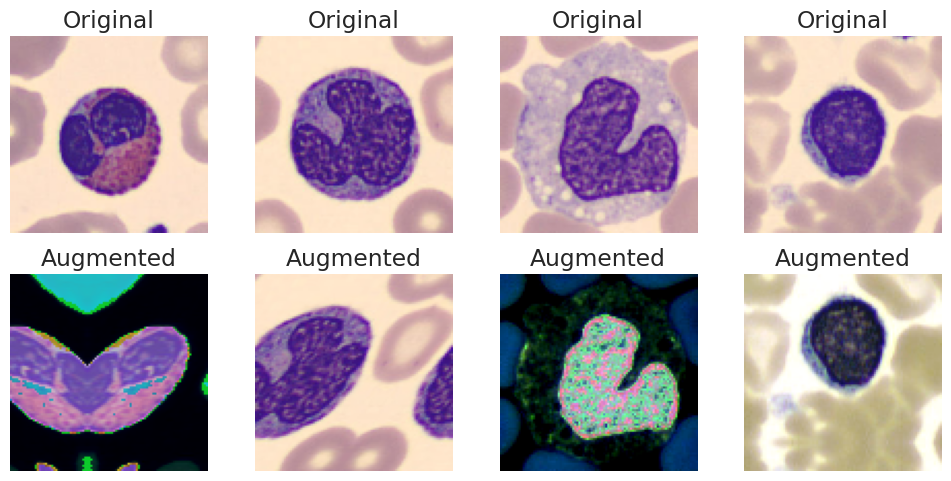

In [15]:
# plotting augemented images from RandAugment

num_images = 4

plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Display original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(X_train[i]/255)
    plt.title("Original")
    plt.axis("off")
    
    # Display augmented image
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(X_train_augmented[i].numpy().astype('float32'))  # Convert to NumPy for display
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

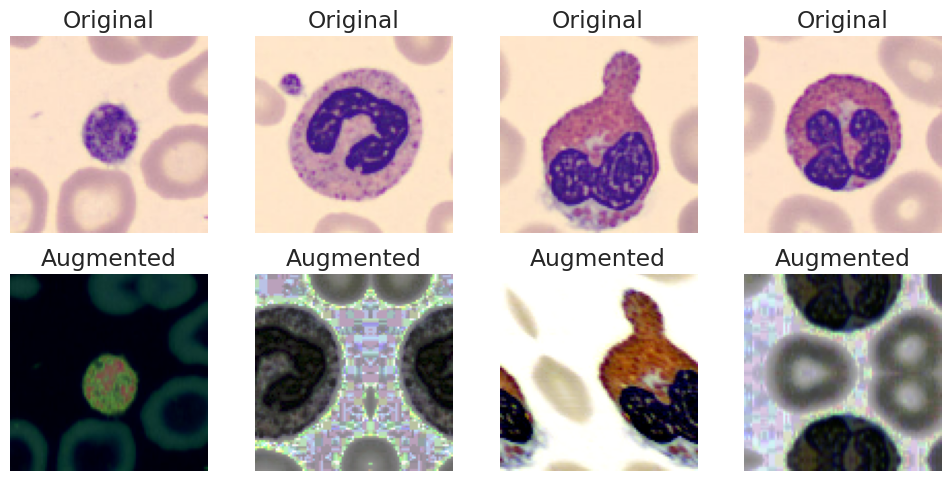

In [17]:
num_images = 4

plt.figure(figsize=(10, 5))
for i in range(num_images):
    # Display original image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(X_val[i]/255)
    plt.title("Original")
    plt.axis("off")
    
    # Display augmented image
    plt.subplot(2, num_images, i + 1 + num_images)
    plt.imshow(X_val_augmented[i].numpy().astype('float32'))  # Convert to NumPy for display
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# First create the new dataset using our `mix_up` utility
train_ds_mu = train_ds.map(
    lambda ds_one, ds_two: mix_up(ds_one, ds_two, alpha=0.2),
    num_parallel_calls=AUTO,
)

# Let's preview 9 samples from the dataset
sample_images, sample_labels = next(iter(train_ds_mu))
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(sample_images[:9], sample_labels[:9])):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().squeeze())
    print(label.numpy().tolist())
    plt.axis("off")

# Standart Augmentations

In [18]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(factor = (-0.5, 0.3), fill_mode="nearest"),
    tfkl.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest', interpolation='bilinear'),
    tfkl.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='reflect', interpolation='bilinear'),
    #tfkl.RandomContrast(0.2),
    #tfkl.RandomBrightness(0.4, value_range=[0.0, 1.0]),
], name='augmentations')

# Model creating

In [19]:
def build_model(model_name, input_shape=(96, 96, 3), num_classes=8, augmentation=tf.keras.Sequential([tfkl.RandomFlip("horizontal_and_vertical")])):

    if model_name == 'VGG16':
        base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'VGG19':
        base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'InceptionV3':
        base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ConvNeXtBase':
        base_model = tfk.applications.ConvNeXtBase(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg', include_preprocessing=True)
    elif model_name == 'Xception':
        base_model = tfk.applications.Xception(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
    elif model_name == 'EfficientNetV2S':
        base_model = tfk.applications.EfficientNetV2S(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
        
    
    inputs = tfkl.Input(shape=input_shape, name='Input')
    x = augmentation(inputs)
    x = base_model(x)

    # Add a dropout layer for regularisation
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)


    # Add final Dense layer for classification with softmax activation
    outputs = tfkl.Dense(num_classes, activation='softmax', name='last_dense')(x)
    

    # Create the final model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    return model

In [20]:
model_name = 'EfficientNetV2S'
model = build_model(model_name, augmentation = augmentation)

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
model.summary(show_trainable=True)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ Input (InputLayer)          │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ augmentations (Sequential)  │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ efficientnetv2-s            │ (None, 1280)          │ 20,331,360 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  1,311,744 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ last_dense (Dense)          │ (None, 8)             │      8,200 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,651,304 (82.59 MB)

 Trainable params: 1,319,944 (5.04 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

# Initialise call backs for changing Learning Rate, model saving and early stopping

In [22]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"{model_name}_best.keras",             # Path to save the model file
    monitor='val_accuracy',               # Metric to monitor
    save_best_only=True,                  # Save only the best model
    mode='max',                           # Mode ('max' for accuracy, 'min' for loss)
    save_weights_only=False,              # Set to True to save only weights, not model architecture
    verbose=1                             # Print a message when saving a new best model
)

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 10,
                                                 factor = 0.9,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00001)

patience = 30

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Freeze all backbone layers

In [ ]:
for layer in model.layers[2].layers:
    layer.trainable = False  # Optional: explicitly freeze BatchNorm layers

# Trying reinitialaize learning rate after several epochs

In [85]:
model.optimizer.learning_rate.assign(0.001)
model.optimizer.learning_rate.value

<tf.Variable 'adam/learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [80]:
model.load_weights("Xception_best.keras")

In [84]:
model.optimizer.learning_rate.value

<tf.Variable 'adam/learning_rate:0' shape=() dtype=float32, numpy=4.1006253e-05>

In [23]:
train_history = model.fit(
    x=X_train,# train_ds_mu,
    y=y_train,
    batch_size=batch_size,
    epochs=50,
    validation_data=(X_val, y_val), #val_ds,
    verbose=1,
    callbacks = [cp_callback, early_stopping, reduce_lr]
).history

Epoch 1/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6589 - loss: 0.9627
Epoch 1: val_accuracy improved from -inf to 0.81240, saving model to EfficientNetV2S_best.keras
336/336 ━━━━━━━━━━━━━━━━━━━━ 47s 66ms/step - accuracy: 0.6591 - loss: 0.9620 - val_accuracy: 0.8124 - val_loss: 0.4937 - learning_rate: 0.0010
Epoch 2/50
335/336 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8075 - loss: 0.5397
Epoch 2: val_accuracy improved from 0.81240 to 0.85678, saving model to EfficientNetV2S_best.keras
336/336 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.8076 - loss: 0.5396 - val_accuracy: 0.8568 - val_loss: 0.4116 - learning_rate: 0.0010
Epoch 3/50
336/336 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8394 - loss: 0.4544
Epoch 3: val_accuracy improved from 0.85678 to 0.86265, saving model to EfficientNetV2S_best.keras
336/336 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.8394 - loss: 0.4544 - val_accuracy: 0.8626 - val_loss: 0.3823 - learning_rate: 0.0010
Epoch 4/50
335/3

# Model uploading and checking poratbility

In [58]:
#%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('EfficientNetV2S_best.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        #if np.max(X)>1:
        #    X = (X/255.0)#.astype("float32")
        #print(X.max())
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

In [59]:
model_uploaded = Model()

In [60]:
prediction = model_uploaded.predict(X_val)

1.0
38/38 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step


In [61]:
sum(prediction == y_val.argmax(axis=1))/len(prediction)

0.14489112227805695

In [31]:
y_val.argmax(axis=1)

array([7, 6, 1, ..., 5, 6, 2])

# Saving submission

In [53]:
from datetime import datetime
filename = f'EfficientNetV2S_{datetime.now().strftime("%y-%m-%d_%H-%M-%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py 'EfficientNetV2S_best.keras'

  adding: model.py (deflated 54%)
  adding: EfficientNetV2S_best.keras (deflated 9%)


# Additional materials (used in some cases to try obtain better results) (does not compile in last version)

In [1]:
def augment_classes(X, y, augmentation, target_classes, multiplier=2):
    """
    Duplicates and augments images for the specified classes.
    Args:
        X: Input images, shape (n_samples, height, width, channels)
        y: Corresponding labels, shape (n_samples, 1)
        augmentation: tf.keras.Sequential of augmentations
        target_classes: List of classes to augment
        multiplier: Number of times to increase the dataset for the target classes
    Returns:
        Augmented X and y
    """
    X_augmented = []
    y_augmented = []

    # Iterate over the target classes
    for target_class in target_classes:
        # Get indices of the target class
        target_indices = np.where(y.flatten() == target_class)[0]

        # Extract the images and labels for the target class
        X_target = X[target_indices]
        y_target = y[target_indices]

        # Augment images for the target class
        for _ in range(multiplier):
            for image, label in zip(X_target, y_target):
                # Expand dims for single image, augment, and squeeze back
                augmented_image = augmentation(tf.expand_dims(image, 0))[0]
                X_augmented.append(augmented_image.numpy())
                y_augmented.append(label)
                
    # Combine original and augmented datasets
    X_augmented = np.array(X_augmented, dtype=np.float32)
    y_augmented = np.array(y_augmented, dtype=np.int32)

    # Return combined dataset
    return np.concatenate([X, X_augmented], axis=0), np.concatenate([y, y_augmented], axis=0)

In [ ]:
augmentation_base = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomRotation(factor = (-0.3, 0.3)),
    tfkl.RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), interpolation='bilinear'),
    tfkl.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), interpolation='bilinear'),
], name='augmentations_base')

In [ ]:
data = np.load('trainig_set_no_outliers.npz')
X = data['images']
y = data['labels']

In [ ]:
# Apply augmentation for multiple classes (e.g., class 0 and class 1) Oversampling dataset
target_classes = [0, 2, 4, 5] 
X, y = augment_classes(X, y, augmentation_base, target_classes, multiplier=2)

In [ ]:
np.savez_compressed('balanced_training_set.npz', images=X, labels=y)

In [ ]:
def remove_outliers(X, y,
                      shrek_hash='6cf0f392e57a6c16165d9b84c885ff78',
                      guy_hash='e2a4597c107ff8683737443da52bfb58'):
    """
    Removes outliers images from array X and their corresponding labels from array y.

    Parameters:
    X : numpy.ndarray - an array of images (for example, shape = (n, height, width))
    y : numpy.ndarray - an array of labels (for example, shape = (n,))

    Returns:
    X_clear : numpy.ndarray - an array of images without outliers
    y_clear : numpy.ndarray - an array of labels without outliers
    """
    X_clear = []
    y_clear = []

    for img, label in zip(X, y):
      img_hash = hashlib.md5(img).hexdigest()
      if img_hash != shrek_hash and img_hash != guy_hash:
        X_clear.append(img)
        y_clear.append(label[0])

    X_clear = np.array(X_clear)
    y_clear = np.array(y_clear)

    return X_clear, y_clear


In [ ]:
X_clear, y_clear = remove_outliers(
    X, y,
    shrek_hash = hashlib.md5(X[12936]).hexdigest(),
    guy_hash = hashlib.md5(X[13699]).hexdigest()
    )

# Policy managment (used several times, but not in latest solutions, to avoid problems with variable types)

In [ ]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [ ]:
# This code used for mix up augmentations (where need two datasets)

train_ds_one = (
    tf_data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(batch_size * 1000)
    .batch(batch_size)
)
train_ds_two = (
    tf_data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(batch_size * 1000)
    .batch(batch_size)
)
# Because we will be mixing up the images and their corresponding labels, we will be
# combining two shuffled datasets from the same training data.
train_ds = tf_data.Dataset.zip((train_ds_one, train_ds_two))

val_ds = tf_data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Freezeing everything except Batch normalisation for fine tuning

In [ ]:
for layer in model.layers:
    # Check if the layer is not a BatchNormalization layer
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False  # Optional: explicitly freeze BatchNorm layers